In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/purzelrakete/src/github.com/feldberlin/deepspeech


In [2]:
import os

import numpy as np
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
import IPython.display as ipd
import wandb

from deepspeech import model, train, datasets, utils

/Users/purzelrakete/src/github.com/feldberlin/deepspeech/.venv/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


# YesNo

In [3]:
p = model.HParams(graphemes=['א', 'כ', 'ל', 'ן', ' ', '	'])
ds = datasets.yesno(p)

In [4]:
def display(i):
    x, y = ds[i]
    xin, _, yin = ds.data.data[i]
    ipd.display(ipd.Audio(xin, rate=p.sampling_rate))
    print(yin, y)
    plt.figure(figsize=(20, 20))
    plt.imshow(x.log2().detach().numpy())
    plt.plot()

/Users/purzelrakete/src/github.com/feldberlin/deepspeech/.venv/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/Users/purzelrakete/src/github.com/feldberlin/deepspeech/.venv/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


[0, 0, 0, 0, 1, 1, 1, 1] ןכ ןכ ןכ ןכ אל אל אל אל


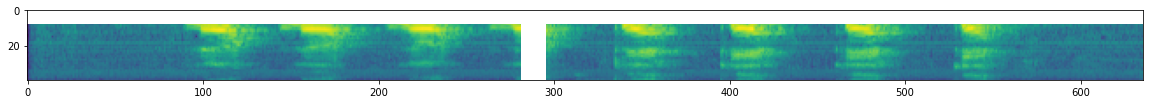

In [5]:
display(0)

[0, 0, 0, 1, 0, 0, 0, 1] ןכ אל אל אל ןכ אל אל אל


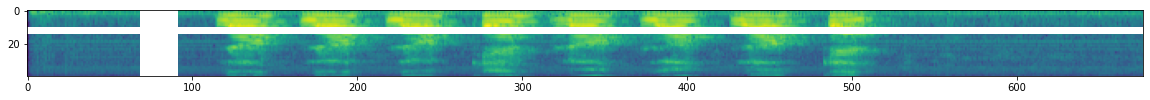

In [6]:
display(1)

[0, 0, 0, 1, 0, 1, 1, 0] אל ןכ ןכ אל ןכ אל אל אל


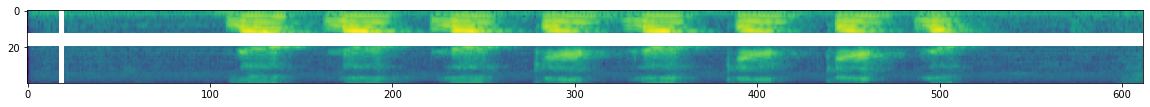

In [7]:
display(2)

[0, 0, 1, 0, 0, 0, 1, 0] אל ןכ אל אל אל ןכ אל אל


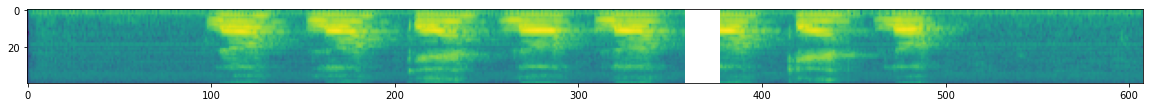

In [8]:
display(3)

## Collation

In [10]:
batch_size = 5
x, y, nx, ny = datasets.batch(p)([ds[i] for i in range(batch_size)])
nx_dowsampled = p.frame_lengths(nx)

In [11]:
nx, ny

(tensor([636, 677, 612, 608, 603]), tensor([23, 23, 23, 23, 23]))

In [12]:
y

tensor([[3, 1, 4, 3, 1, 4, 3, 1, 4, 3, 1, 4, 0, 2, 4, 0, 2, 4, 0, 2, 4, 0, 2],
        [3, 1, 4, 0, 2, 4, 0, 2, 4, 0, 2, 4, 3, 1, 4, 0, 2, 4, 0, 2, 4, 0, 2],
        [0, 2, 4, 3, 1, 4, 3, 1, 4, 0, 2, 4, 3, 1, 4, 0, 2, 4, 0, 2, 4, 0, 2],
        [0, 2, 4, 3, 1, 4, 0, 2, 4, 0, 2, 4, 0, 2, 4, 3, 1, 4, 0, 2, 4, 0, 2],
        [0, 2, 4, 3, 1, 4, 3, 1, 4, 0, 2, 4, 0, 2, 4, 3, 1, 4, 0, 2, 4, 0, 2]])

In [13]:
for i in range(batch_size):
    print('want: ', ds[i][1])
    print('gots: ', ''.join([p.graphemes[int(c)] for c in y[i]]))
    print()

want:  ןכ ןכ ןכ ןכ אל אל אל אל
gots:  ןכ ןכ ןכ ןכ אל אל אל אל

want:  ןכ אל אל אל ןכ אל אל אל
gots:  ןכ אל אל אל ןכ אל אל אל

want:  אל ןכ ןכ אל ןכ אל אל אל
gots:  אל ןכ ןכ אל ןכ אל אל אל

want:  אל ןכ אל אל אל ןכ אל אל
gots:  אל ןכ אל אל אל ןכ אל אל

want:  אל ןכ ןכ אל אל ןכ אל אל
gots:  אל ןכ ןכ אל אל ןכ אל אל



In [14]:
for i in range(batch_size):
    print('melgram: ', ds[i][0].shape)
    print('audio: ', ds.data.data[i][0].shape)
    print('batch: ', x[i].shape)
    print('nx: ', nx[i])
    print('nx_dowsampled: ', nx_dowsampled[i])
    print('ny: ', ny[i])
    print()

melgram:  torch.Size([40, 636])
audio:  torch.Size([1, 50800])
batch:  torch.Size([40, 677])
nx:  tensor(636)
nx_dowsampled:  tensor(318)
ny:  tensor(23)

melgram:  torch.Size([40, 677])
audio:  torch.Size([1, 54080])
batch:  torch.Size([40, 677])
nx:  tensor(677)
nx_dowsampled:  tensor(339)
ny:  tensor(23)

melgram:  torch.Size([40, 612])
audio:  torch.Size([1, 48880])
batch:  torch.Size([40, 677])
nx:  tensor(612)
nx_dowsampled:  tensor(306)
ny:  tensor(23)

melgram:  torch.Size([40, 608])
audio:  torch.Size([1, 48560])
batch:  torch.Size([40, 677])
nx:  tensor(608)
nx_dowsampled:  tensor(304)
ny:  tensor(23)

melgram:  torch.Size([40, 603])
audio:  torch.Size([1, 48160])
batch:  torch.Size([40, 677])
nx:  tensor(603)
nx_dowsampled:  tensor(302)
ny:  tensor(23)



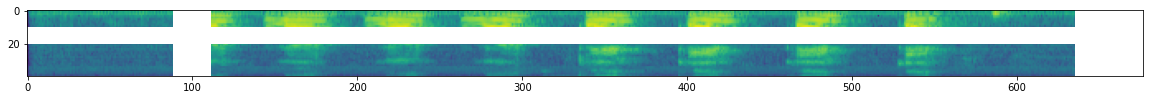

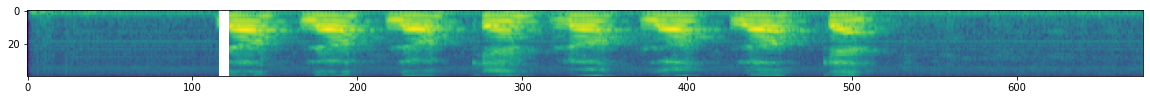

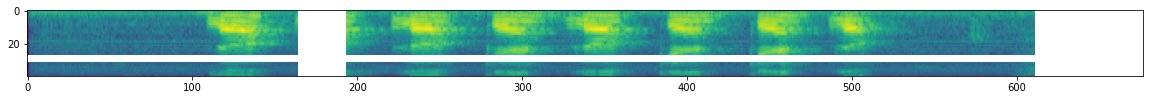

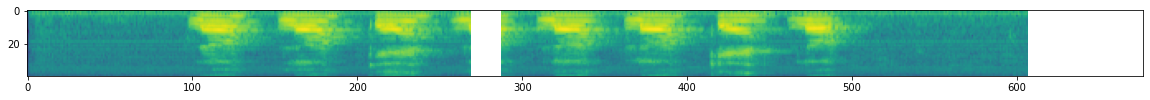

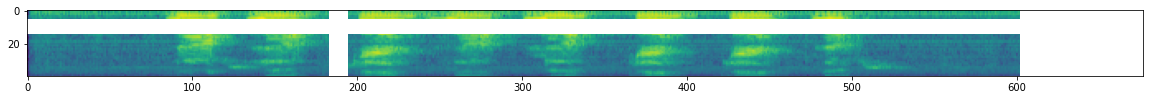

In [15]:
for i in range(batch_size):
    plt.figure(figsize=(20, 20))
    plt.imshow(x[i].log2().detach().numpy())